# Gender and Testimony - Extracting Language Patterns with spaCy

### Before We Begin . . .

This Notebook expects you to review [Lauren Klein's](https://github.com/laurenfklein/emory-qtm340/blob/master/notebooks/class11-nlp-spacy-complete.ipynb) "crash course" introduction to natural language processing (NLP).

### The Ongoing Problem of Data-Driven Text Analysis

The process of extracting meaningful language patterns poses underlying challenges for any data-driven textual analysis. Here, this challenge is imagined as two-fold: analysts must determine which patterns are "meaningful" and analysts must apply the appropriate methods and tools to extract these meaningful patterns.

Determining which patterns are meaningful might not be immediately clear when working with an unfamiliar corpus, or when working with a familiar corpus that has complexities beyond what we thought we knew. Noticing new patterns or ideas is a common experience when re-reading a familiar text through a different angle.

Deciding which language patterns are meaningful should therefore be a critical, iterative process. We must ask guiding questions and also evaluate the efficacy of these questions. What kinds of rabbit holes do our questions lead us down? Are there risks involved in the way we ask questions--risks such as distorting the subject matter at hand in order to confirm our own biases?

Analysts must also match guiding questions with an appropriate technique while being mindful that the methods and tools used to measure a corpus also give shape to the corpus and our analysis.

The purpose of this Notebook is to engage with this two-fold problem while text mining with spaCy NLP. In this exercise we will algorithmically read the 1870 Hansard debates with the purpose of analyzing word co-occurance of grammatical gendered pronoun-verb pairs. These pairs are not necessarily consecutive, like bigrams, but instead share syntactic relations in a sentence.

To explore how technique and analysis go hand-in-hand, this Notebook will ask a high-level, guiding question about gender: what kinds of actions are associated with male and female pronouns in 1870? 

### Why spaCy?

spaCy is a comprehensive, industrial-grade software library for natural language processing (NLP). It provides tools to extract language patterns. From a linguistic standpoint, spaCy outperforms popular tools like NLTK because spaCy offers advanced statistical language models from which it parses and tags words.

spaCy's NLP pipeline is shown below. Provided with text, spaCy can tokenize, tag, parse, perform named entity recognition, and more. 

The pipeline returns a parsed `Doc` object.

<img src="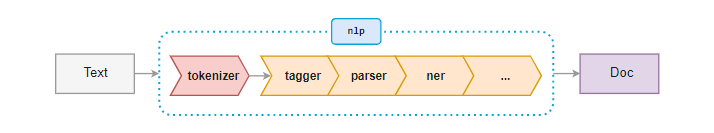
">

spaCy's [linguistic features](https://spacy.io/usage/linguistic-features) include:

#### 1. Syntactic dependency parsing

Syntax is the ordering from which words derive meaning within a sentence. After parsing words' syntactic dependencies, analysts can reconstruct grammatical rules for the purpose of extracting parts-of-speech.

#### 2. Part-of-speech tagging

Parts-of-speech are lexical categories that corresponds with a word's syntactic function--categories like "adjective" or "verb." spaCy tags parts-of-speech using a statistical model to predict which tag should most likely appear in a given context. 

#### 3. Rule-based morphology

Morphology refers to word form and how different forms relate to other words in a sentence. Consider the verbs "write" and "writing" in the following sentences: 

    "I write programs."
    "I am writing a program."

The later is called an inflectional form. It is important to note that inflectional forms do not change a word's part-of-speech.

Morphology is important to the process of lemmatization, or transforming words to their base form. Lemmatizing words before measuring them can streamline our results so words like "rent" and "rented" are not counted separately.

#### 4. Tokenization

Tokenization is the process of splitting texts into meaningful segments like n-grams. spaCy has tokenization support for over [59 languages](https://spacy.io/usage/models).

#### 5. Entity Extraction

spaCy offers entity recognition for a variety of named and numeric entities including locations, person names, and organizations. Users can also add their own classes of entities.

### Getting Started on M2

First import spaCy.

In [1]:
import spacy, warnings; warnings.simplefilter('ignore')

spaCy's language model can be loaded with `spacy.load()`. `spacy.load()` returns a `Language` object with the components and data required to process text such as a tagger and a tokenizer. 

For convention's-sake we will call our `Language` object `nlp`.

In [2]:
nlp = spacy.load('en_core_web_sm')

### Loading the Hansard data

The following code reads in the Hansard data as a pandas DataFrame.

In [3]:
%%time
import datetime as dt
import pandas as pd

all_hansard = pd.read_parquet("/scratch/group/oit_research_data/hansard/hansard_20191119.parquet")

CPU times: user 1min 53s, sys: 45.9 s, total: 2min 39s
Wall time: 2min 46s


In [4]:
all_hansard

,sentence_id,src_file_id,file_section_id,section_sentence_id,section_monologue_id,speech_id,debate_id,speechdate,debate,section_category,text,speaker,constituency,speaker_house,src_image,src_column,sentence_errata,sentence_entities,entity_labels,Unnamed: 19
0,S1V0001P0_0,S1V0001P0,0,0,0,0,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,moved that Lord Walsingham be appointed chairm...,Lord Hawkesbury,None,HOUSE OF LORDS.,S1V0001P0I0024,11,False,Walsingham,PERSON,None
1,S1V0001P0_1,S1V0001P0,0,1,0,1,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,"in seconding the motion, took an opportunity t...","The Lord Chancellor,",None,HOUSE OF LORDS.,S1V0001P0I0024,11,False,None,None,None
2,S1V0001P0_2,S1V0001P0,0,2,1,1,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,"—The question was put, and the appointment for...","The Lord Chancellor,",None,HOUSE OF LORDS.,S1V0001P0I0024,11,False,None,None,None
3,S1V0001P0_3,S1V0001P0,0,3,0,2,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,"then rose, and observed, that he was not in th...",Lord Walsingham,None,HOUSE OF LORDS.,S1V0001P0I0024,12,False,two,CARDINAL,None
4,S1V0001P0_4,S1V0001P0,0,4,1,2,0,1803-11-22,[COMMITTEE OF PRIVILEGES]—,Uncategorized,He had to return his thanks to the House for t...,Lord Walsingham,None,HOUSE OF LORDS.,S1V0001P0I0024,12,False,"House,House,House","ORG,ORG,ORG",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71565564,S6CV0424P2_24427,S6CV0424P2,4001,1,1,10249070,1930316,2004-07-19,Speech Therapists,Uncategorized,[189367],Bob Spink,None,Written Ministerial Statements,S6CV0424P2I1101,1999W,False,189367,DATE,None
71565565,S6CV0424P2_24428,S6CV0424P2,4001,2,0,10249071,1930316,2004-07-19,Speech Therapists,Uncategorized,The information requested is not collected cen...,Mr. Hutton,None,Written Ministerial Statements,S6CV0424P2I1101,2000W,False,None,None,None
71565566,S6CV0424P2_24429,S6CV0424P2,4002,0,0,10249072,1930317,2004-07-19,Vancomycin-resistant Enterococcus,Uncategorized,To ask the Secretary of State for Health how m...,Mr. Iris Robinson,None,Written Ministerial Statements,S6CV0424P2I1101,2000W,False,"State for Health,each of the last 10 years","ORG,DATE",None
71565567,S6CV0424P2_24430,S6CV0424P2,4002,1,1,10249072,1930317,2004-07-19,Vancomycin-resistant Enterococcus,Uncategorized,[187444],Mr. Iris Robinson,None,Written Ministerial Statements,S6CV0424P2I1101,2000W,False,187444,DATE,None


After loading all of Hansard we can take a subset (or portion) of the data set that is relevant to our analysis.

The following code creates a subset of the data for just the decade 1870.

In [5]:
all_hansard['speechdate'] = pd.to_datetime(all_hansard['speechdate'], errors = 'coerce')

hansard_1870 = all_hansard[(all_hansard['speechdate'] >= dt.datetime(1870,1,1)) & (all_hansard['speechdate'] <= dt.datetime(1879,12,31))]

In [6]:
hansard_1870

,sentence_id,src_file_id,file_section_id,section_sentence_id,section_monologue_id,speech_id,debate_id,speechdate,debate,section_category,text,speaker,constituency,speaker_house,src_image,src_column,sentence_errata,sentence_entities,entity_labels,Unnamed: 19
4692304,S3V0199P0_0,S3V0199P0,0,0,0,342939,41076,1870-02-08,THE QUEEN'S SPEECH.,Uncategorized,delivered HER MAJESTY'S SPEECH to both Houses ...,THE LORD CHANCELLOR,None,"HOUSE OF LORDS,",S3V0199P0I0051,2,False,"SPEECH,Houses of Parliament","ORG,ORG",None
4692305,S3V0199P0_1,S3V0199P0,4,0,0,342940,41077,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,Uncategorized,"My Lords, I rise to move that a humble Address...",THE MARQUESS OF HUNTLY,None,"HOUSE OF LORDS,",S3V0199P0I0054,7,False,My Lords,PERSON,None
4692306,S3V0199P0_2,S3V0199P0,4,1,1,342940,41077,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,Uncategorized,I venture to ask your Lordships' indulgence in...,THE MARQUESS OF HUNTLY,None,"HOUSE OF LORDS,",S3V0199P0I0054,7,False,Lordships,ORG,None
4692307,S3V0199P0_3,S3V0199P0,4,2,2,342940,41077,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,Uncategorized,I trust that any errors I may be guilty of may...,THE MARQUESS OF HUNTLY,None,"HOUSE OF LORDS,",S3V0199P0I0054,7,False,Lordships,ORG,None
4692308,S3V0199P0_4,S3V0199P0,4,3,3,342940,41077,1870-02-08,THE QUEEN'S SPEECH— ADDRESS IN ANSWER TO HER M...,Uncategorized,I am sure your Lordships will have heard with ...,THE MARQUESS OF HUNTLY,None,"HOUSE OF LORDS,",S3V0199P0I0054,7,False,"Lordships,Majesty","ORG,PRODUCT",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5822719,S3V0249P0_13044,S3V0249P0,10,26,17,445135,55124,1879-08-15,ROYAL COMMISSIONS—REPORTS AND EVIDENCE. —QUEST...,Uncategorized,Gentleman may be assured that no undue partial...,MR. GOSCHEN,None,"HOUSE OF COMMONS,",S3V0249P0I0548,1039,False,Gentleman,ORG,None
5822720,S3V0249P0_13045,S3V0249P0,11,0,0,445136,55125,1879-08-15,OFFENSIVE PRINTS. —QUESTION.,Uncategorized,asked the Secretary of State for the Home De- ...,SIR PATRICK O'BRIEN,None,"HOUSE OF COMMONS,",S3V0249P0I0548,1039,False,"State,the last few weeks,London","ORG,DATE,GPE",None
5822721,S3V0249P0_13046,S3V0249P0,11,1,0,445137,55125,1879-08-15,OFFENSIVE PRINTS. —QUESTION.,Uncategorized,"Sir, in reference to a reply which I recently ...",MR. ASSHETON CROSS,None,"HOUSE OF COMMONS,",S3V0249P0I0548,1040,False,None,None,None
5822722,S3V0249P0_13047,S3V0249P0,11,2,1,445137,55125,1879-08-15,OFFENSIVE PRINTS. —QUESTION.,Uncategorized,I do not retract anything that I said on a for...,MR. ASSHETON CROSS,None,"HOUSE OF COMMONS,",S3V0249P0I0548,1040,False,None,None,None


After subsetting the data we can free some of our memory by deleting `all_hansard` (since we won't be taking any more subsets).

In [7]:
del all_hansard

We can speed processing time by just operating on the columns we need for our analysis, `sentence_id` and `text`, where `sentence_id` is a unique identifier and `text` is the Hansard debate text.

In [8]:
hansard_text = hansard_1870[['sentence_id','text']].copy()

In [9]:
hansard_text

,sentence_id,text
4692304,S3V0199P0_0,delivered HER MAJESTY'S SPEECH to both Houses ...
4692305,S3V0199P0_1,"My Lords, I rise to move that a humble Address..."
4692306,S3V0199P0_2,I venture to ask your Lordships' indulgence in...
4692307,S3V0199P0_3,I trust that any errors I may be guilty of may...
4692308,S3V0199P0_4,I am sure your Lordships will have heard with ...
...,...,...
5822719,S3V0249P0_13044,Gentleman may be assured that no undue partial...
5822720,S3V0249P0_13045,asked the Secretary of State for the Home De- ...
5822721,S3V0249P0_13046,"Sir, in reference to a reply which I recently ..."
5822722,S3V0249P0_13047,I do not retract anything that I said on a for...


### Parsing Text with spaCy

As demonstrated in [Klein's Notebook](https://github.com/laurenfklein/emory-qtm340/blob/master/notebooks/class11-nlp-spacy-complete.ipynb), invoking `nlp` on a string of text will return a processed `Doc` object. Within each `Doc` object is a spaCy `token` object. From these `token` objects we can access a word's lemmatized form, its part-of-speech, and other attributes.

Unlike Klein's data, however, ours is in a data frame where each row is a string of text. We must iterate through each row of the data frame with `nlp.pipe()`, which processes the data in small batches. To improve parsing time we can disable features that we will not use for this exercise like named entity recognition (or `ent`).

In [10]:
hansard_text['parsed_text'] = list(nlp.pipe(hansard_text['text'], disable = ["ent"], batch_size=100))

In [11]:
hansard_text

,sentence_id,text,parsed_text
4692304,S3V0199P0_0,delivered HER MAJESTY'S SPEECH to both Houses ...,"(delivered, HER, MAJESTY, 'S, SPEECH, to, both..."
4692305,S3V0199P0_1,"My Lords, I rise to move that a humble Address...","(My, Lords, ,, I, rise, to, move, that, a, hum..."
4692306,S3V0199P0_2,I venture to ask your Lordships' indulgence in...,"(I, venture, to, ask, your, Lordships, ', indu..."
4692307,S3V0199P0_3,I trust that any errors I may be guilty of may...,"(I, trust, that, any, errors, I, may, be, guil..."
4692308,S3V0199P0_4,I am sure your Lordships will have heard with ...,"(I, am, sure, your, Lordships, will, have, hea..."
...,...,...,...
5822719,S3V0249P0_13044,Gentleman may be assured that no undue partial...,"(Gentleman, may, be, assured, that, no, undue,..."
5822720,S3V0249P0_13045,asked the Secretary of State for the Home De- ...,"(asked, the, Secretary, of, State, for, the, H..."
5822721,S3V0249P0_13046,"Sir, in reference to a reply which I recently ...","(Sir, ,, in, reference, to, a, reply, which, I..."
5822722,S3V0249P0_13047,I do not retract anything that I said on a for...,"(I, do, not, retract, anything, that, I, said,..."


`hansard_text` now contains a column named `parsed_text`. Note how `parsed_text` looks different from `text`: every sentence is surrounded by `()` and every word is separated by a comma. These symbols tell us that every sentence is now in a spaCy `doc` object and every word is a spaCy `token` object where each token is an individual word.

### Processing spaCy `token` Objects for Part-of-Speech Extraction

For our analysis, we are just interested in the spaCy `token` objects inside the `doc` objects. The `token` objects include attributes such as:

 - `.text`: the original word
 - `.lemma_`: the word's lemmatized form
 - `.pos_`: the word's part-of-speech
 - `.dep_`: the word's syntactic dependency
 - `.head.text`: the word upon which the present word is dependent

These attributes can be viewed by iterating through each `doc` object like the following code:

In [12]:
def extractTokens(spacy_doc_object):
    spacy_tokens = []
    for doc in spacy_doc_object['parsed_text']:
        for token in doc:
            row = (token.text, token.lemma_, token.pos_, token.dep_, token.head.text)
            spacy_tokens.append(row)
    return spacy_tokens

hansard_tokens = extractTokens(hansard_text)

In [13]:
hansard_tokens[:30]

[('delivered', 'deliver', 'VERB', 'ROOT', 'delivered'),
 ('HER', 'her', 'DET', 'poss', 'MAJESTY'),
 ('MAJESTY', 'MAJESTY', 'PROPN', 'poss', 'SPEECH'),
 ("'S", "'s", 'PART', 'case', 'MAJESTY'),
 ('SPEECH', 'speech', 'NOUN', 'dobj', 'delivered'),
 ('to', 'to', 'ADP', 'prep', 'delivered'),
 ('both', 'both', 'DET', 'det', 'Houses'),
 ('Houses', 'Houses', 'PROPN', 'pobj', 'to'),
 ('of', 'of', 'ADP', 'prep', 'Houses'),
 ('Parliament', 'Parliament', 'PROPN', 'pobj', 'of'),
 (',', ',', 'PUNCT', 'punct', 'delivered'),
 ('as', 'as', 'SCONJ', 'mark', 'follows'),
 ('follows', 'follow', 'VERB', 'advcl', 'delivered'),
 (':', ':', 'PUNCT', 'punct', 'delivered'),
 ('—', '—', 'PUNCT', 'punct', 'delivered'),
 ('My', '-PRON-', 'DET', 'poss', 'Lords'),
 ('Lords', 'Lords', 'PROPN', 'npadvmod', 'rise'),
 (',', ',', 'PUNCT', 'punct', 'rise'),
 ('I', '-PRON-', 'PRON', 'nsubj', 'rise'),
 ('rise', 'rise', 'VERB', 'ROOT', 'rise'),
 ('to', 'to', 'PART', 'aux', 'move'),
 ('move', 'move', 'VERB', 'advcl', 'rise'),


Before continuing, let's take a moment to observe the output of `hansard_tokens`.

`hansard_tokens` is split into one token per row. Alongside each token is: a) the token, b) the token's lemmatized form, c) the tokens part-of-speech, d) the token's syntactic function, and e) the token's "head", or the token to which it syntactically depends.

### Extracting Parts-of-Speech from Parsed Hansard Text

Now we can begin extracting grammatical parts-of-speech for the purpose of looking for language trends. The following code extracts grammatical pairs where the subject is tagged as a noun subject or passive noun subject and is also a "child" of a verb (or has the verb as its head). 

The verb is lemmatized to prevent counting inflectional verbs separately from their base form.

In [14]:
from spacy.symbols import nsubj, nsubjpass, VERB

def extractPairs(spacy_doc_object):
    pairs = []
    for doc in spacy_doc_object['parsed_text']:
        for subject in doc:
            if subject.dep == nsubj or subject.dep == nsubjpass and subject.head.pos == VERB:
                extracted_pairs = subject.text, subject.head.lemma_
                concat_extracted_pairs = ' '.join(extracted_pairs)
                pairs.append(str(concat_extracted_pairs))
    return pairs

pairs = extractPairs(hansard_text)

In [15]:
pairs[:30]

['I rise',
 'Address present',
 'I venture',
 'I undertake',
 'I trust',
 'errors lay',
 'I be',
 'Lordships look',
 'I be',
 'Lordships hear',
 'I be',
 'she suffer',
 'which make',
 'it impossible',
 'her execute',
 'relations be',
 'It be',
 'words refer',
 'which lead',
 'it be',
 'I regret',
 'settlement ratify',
 'which agree',
 'differences receive',
 'it be',
 'they adjust',
 'it gratify',
 'feeling exist',
 'it be',
 'countries be']

`pairs` is a list subjects followed by verbs.

For the sake of counting and matching with words regardless of case, we can transform all words to lower case.

In [16]:
lowercase_pairs = [word.lower() for word in pairs]

In [17]:
lowercase_pairs[:30]

['i rise',
 'address present',
 'i venture',
 'i undertake',
 'i trust',
 'errors lay',
 'i be',
 'lordships look',
 'i be',
 'lordships hear',
 'i be',
 'she suffer',
 'which make',
 'it impossible',
 'her execute',
 'relations be',
 'it be',
 'words refer',
 'which lead',
 'it be',
 'i regret',
 'settlement ratify',
 'which agree',
 'differences receive',
 'it be',
 'they adjust',
 'it gratify',
 'feeling exist',
 'it be',
 'countries be']

<div class="alert alert-block alert-info">
Remember to capitalize I before turning in your paper.
</div>

We can narrow these results to just pairs containing gendered pronouns for the purpose of exploring our guiding question: what kinds of actions are associated with male and female pronouns in the decade 1870?

### Filtering for Gendered Pronoun-Verb Pairs

The goal of this Notebook is to extract gendered pronoun-verb pairs and create visualizations that compare male pronoun-verb pairs and female pronoun-verb pairs. First, however, we will just extract pairs with the pronoun he.

We can search for he and its grammatical verbs by treating he as a regular expression (or sequence of characters that define a search pattern). The following code defines our regular expression, ('he '), and creates a variable for each pair that contains a match.

In [18]:
import re

def extractMalePairs(pairs):
    regex = re.compile('he ')
    male = [word for word in lowercase_pairs if regex.match(word)]
    return male

male = extractMalePairs(lowercase_pairs)

In [19]:
male[:30]

['he show',
 'he refer',
 'he think',
 'he wish',
 'he say',
 'he identify',
 'he venture',
 'he have',
 'he refuse',
 'he refuse',
 'he be',
 'he reply',
 'he do',
 'he allow',
 'he ask',
 'he shoot',
 'he be',
 'he say',
 'he argue',
 'he say',
 'he band',
 'he address',
 'he be',
 'he desire',
 'he overthrow',
 'he overthrow',
 'he overthrow',
 'he be',
 'he make',
 'he become']

Viewing just the first 30 lines of our lists shows us that our gendered pronoun-verb pairs contain stop words like be or say. Pairs containing a stop word can be removed. 

We can do this by first defining our stop words . . . 

In [20]:
stopwords = ['right', 'hon', 'general', 'mr', 'shall', 'majesty', 'exchequer', 'address', 'motion', 'bill',
             'earl', 'friend', 'chancellor', 'sense', 'object', 'suppose', 'amidst', 'noble', 'lord', 'agree',
             'speech', 'kind', 'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september',
             'october', 'november', 'december', 'order', 'held', 'hold', 'assembly', '£', 'humble', 'about', 'above',
             'across', 'address', 'after', 'afterwards', 'again', 'against', 'agree', 'all', 'almost', 'alone', 'along',
             'already', 'also', 'although', 'always', 'am', 'amidst', 'among', 'amongst', 'amount', 'an', 'and', 'another',
             'any', 'anyhow', 'anything', 'anyway', 'anywhere', 'april', 'are', 'around', 'as', 'at', 'back', 'be', 'was',
             'becames', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being',
             'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'do',
             'could', 'did', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'either', 'else', 'elsewhere',
             'empty', 'enough', 'even', 'ever', 'everyone', 'everything', 'everywhere', 'except', 'few', 'first', 'for',
             'from', 'front', 'full', 'further', 'general', 'get', 'give', 'go', 'had', 'has', 'have', 'held', 'hence',
             'here', 'hereby', 'herein', 'hold', 'however', 'if', 'in', 'indeed', 'into', 'is', 'it', 'its', 'itself',
             'just', 'keep', 'kind', 'last', 'latter', 'least', 'less', 'made', 'make', 'many', 'me', 'meanwhile', 'might',
             'mine', 'more', 'most', 'mostly', 'move', 'much', 'must', 'name,' 'neither', 'never', 'nevertheless', 'next',
             'no', 'noble', 'nobody', 'none', 'nor', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'one', 'once',
             'only', 'onto', 'or', 'other', 'others', 'otherwise', 'out', 'over', 'own', 'part', 'perhaps', 'please', 'put',
             'quite', 'rather', 'really', 'regarding', 'same', 'say', 'see', 'seem', 'seemed', 'seeming', 'seems', 'sense',
             'several', 'shall', 'should', 'show', 'side', 'since', 'so', 'some', 'someone', 'something', 'sometime',
             'still', 'such', 'suppose', 'take', 'than', 'that', 'the', 'then', 'there', 'thereby', 'therefore', 'these',
             'they', 'this', 'those', 'though', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'under',
             'unless', 'until', 'up', 'upon', 'us', 'used', 'using', 'various', 'very', 'was', 'we', 'well', 'were', 'what',
             'whatever', 'when', 'when', 'whereby', 'whether', 'which', 'while', 'who', 'why', 'will', 'with', 'within',
             'without', 'would', 'yet', 'bright', 'mr.', 'hansard', 'lancashire', '[]', '£1', '000', 'russell', 'committee',
             'reading', 'learned', 'deal', 'time', 'royal', 'gentlemen', 'gentleman', 'year', 'years', 'affairs', 'affair',
             'academy', 'sir', 'thought', 'took', 'bring', 'brings', 'brought', 'forward', 'great', 'good', 'department',
             'treasury', 'second', 'take', 'taken', 'privy', 'member', 'robert', 'large', 'session', 'secretary', 'notice',
             'moment', 'think', 'believe', 'hope', 'ask', 'hear', 'beg', 'support', 'state', 'find', 'admit', 'wish',
             'refer', 'reply', 'know', 'feel', 'propose', 'understand', 'let', 'allow', 'like', 'receive', 'consider',
             'begin', 'tell', 'like', 'send', 'ought', 'come', 'intend', 'add', 'want', 'stand', 'suggest', 'remind',
             'use', 'mean', 'suggest']

. . . and then matching this list with our pairs to see whether any tokens match a stop word.

The following code removes stop words by a) splitting the pair into individual tokens, b) creating a variable, `tokens_filtered` for just words that do not match a stop word, and c) joining indiviudal words back together to make a pair.

In [21]:
tokens_joined = []

for pair in male:
    tokens = pair.split(" ")
    tokens_filtered = [word for word in tokens if not word in stopwords]
    tokens = " ".join(tokens_filtered)
    tokens_joined.append(str(tokens))

In [22]:
tokens_joined[:30]

['he',
 'he',
 'he',
 'he',
 'he',
 'he identify',
 'he venture',
 'he',
 'he refuse',
 'he refuse',
 'he',
 'he',
 'he',
 'he',
 'he',
 'he shoot',
 'he',
 'he',
 'he argue',
 'he',
 'he band',
 'he',
 'he',
 'he desire',
 'he overthrow',
 'he overthrow',
 'he overthrow',
 'he',
 'he',
 'he']

We have a problem, however. After joining the individual words sans stop words we are left with messy data: some strings only have one word because the other word was removed. We can remove these individual tokens by writing a line of logic that only keeps strings that are the length of two (i.e. strings that are pairs). 

In [23]:
def removeStopWords(pairs):
    keep_pairs = []
    for pair in pairs:
        tokens = pair.split(" ")
        tokens_filtered = [word for word in tokens if not word in stopwords]
        joined_tokens = " ".join(tokens_filtered)
        if len(tokens_filtered) == 2: # if string is length of two
            keep_pairs.append(str(joined_tokens)) # keep the string
    return keep_pairs

male_no_stopwords = removeStopWords(male)

In [24]:
male_no_stopwords[:30]

['he identify',
 'he venture',
 'he refuse',
 'he refuse',
 'he shoot',
 'he argue',
 'he band',
 'he desire',
 'he overthrow',
 'he overthrow',
 'he overthrow',
 'he acknowledge',
 'he shoot',
 'he preach',
 'he protest',
 'he remonstrate',
 'he dismiss',
 'he frankly',
 'he remove',
 'he proceed',
 'he request',
 'he adopt',
 'he oblige',
 'he dismiss',
 'he condemn',
 'he express',
 'he arrive',
 'he write',
 'he venture',
 'he preside']

### Counting Gendered Pronoun-Verb Pairs

After aggregating gendered pronouns that syntactically depend on a verb, we can count the frequency of each pair.

The following code defines a function, `countWords()`, that creates a dictionary of every unique pair and its frequency. Any pair not already in the dictionary is added. If the pair is already part of the dictionary its count increments by 1.

In [25]:
def countWords(clean_data):
    ngrams_dict = {}
    for ngram in clean_data:
        if ngram in ngrams_dict:
            ngrams_dict[ngram] += 1
        else:
            ngrams_dict[ngram] = 1
    return ngrams_dict
            
male_dictionary = countWords(male_no_stopwords)

In [26]:
for kv in list(male_dictionary)[:30]:
    print(kv,  male_dictionary[kv])

he identify 14
he venture 2733
he refuse 376
he shoot 41
he argue 230
he band 2
he desire 2594
he overthrow 5
he acknowledge 244
he preach 20
he protest 889
he remonstrate 11
he dismiss 113
he frankly 1
he remove 140
he proceed 471
he request 152
he adopt 445
he oblige 568
he condemn 176
he express 1539
he arrive 309
he write 504
he preside 121
he mistake 65
he resort 37
he deny 1384
he remark 508
he terrify 4
he witness 72


Dictionaries do not store data in sequential order. This is because a dictionary is "hashable," not linear like a list. While this makes dictionaries quick to process, its organization is not conducive to analysis.

Therefore, we will cast the pronoun-verb pairs and their counts to a pandas data frame.

In [27]:
male_pronoun_verb_counts = pd.DataFrame(male_dictionary.items(),columns = ['Pair','Count'])

In [28]:
male_pronoun_verb_counts

,Pair,Count
0,he identify,14
1,he venture,2733
2,he refuse,376
3,he shoot,41
4,he argue,230
...,...,...
2698,he equitable,1
2699,he damnify,1
2700,he muse,1
2701,he excise,1


After creating a pandas DataFrame with our pronoun-verb pairs we can arrange the frequency counts so pairs with the highest count are first.

In [29]:
male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=False)

In [30]:
male_pronoun_verb_counts

,Pair,Count
106,he trust,4212
1,he venture,2733
6,he desire,2594
134,he regret,2503
56,he speak,2373
...,...,...
1841,he captivate,1
1842,"he says—""no",1
1845,he buoy,1
1849,he gift,1


<div class="alert alert-block alert-info">
Before we continue: one concern had by students was whether it is possible to save variables so that we would not have to rerun spaCy. The answer is: yes, but we need to be mindful of the variable's data structure. During points in our code we can transform our data structure (our dictionary, our list, etc.) to a pandas DataFrame and save the pandas DataFrame to a CSV file. A CSV file looks like an Excel spreadsheet and can be easily read back into your code. The following commented-out example shows how to save a CSV file and then read it back into your Notebook.
</div>

In [35]:
# male_pronoun_verb_counts.to_csv('male_pronoun_verb_counts.csv') # save your variable to a CSV file on disk
# loaded_male_pronoun_verb_counts = pd.read_csv('male_pronoun_verb_counts.csv') # load your CSV file 

### Visualizing our Results for Analysis

We are now ready to visualize our results: grammatical pronoun-verb pairs that show us which verbs are commonly associated with the pronoun he in the 1870 Parliamentary debates.

The following code takes a subset of the first 25 rows of `male_pronoun_verb_counts`.

In [31]:
top_male_pronoun_verb_counts = male_pronoun_verb_counts[:25].copy()

In [32]:
top_male_pronoun_verb_counts

,Pair,Count
106,he trust,4212
1,he venture,2733
6,he desire,2594
134,he regret,2503
56,he speak,2373
259,he vote,1910
164,he mention,1580
339,he contend,1542
20,he express,1539
44,he maintain,1495


These top grammatical pairs can now be visualized with matplotlib. 

The following code imports matplotlib, sets the plot's size, and renders the visualization.

<AxesSubplot:title={'center':'Top Grammatical Pronoun-Verb Pairs with He: Searching the Hansard Parliamentary Debates'}, ylabel='Pair'>

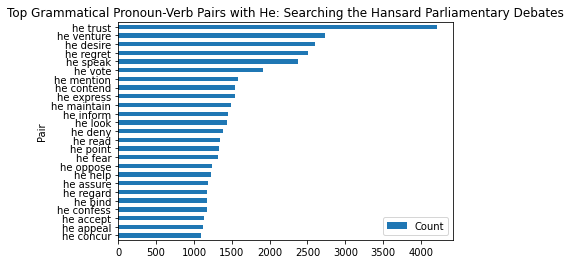

In [33]:
import matplotlib as plt

plt.rcParams['figure.figsize'] = [15, 10]

top_male_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=True)

top_male_pronoun_verb_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Pronoun-Verb Pairs with He: Searching the Hansard Parliamentary Debates")

### Reiterating the Process to Extract Female Grammatical Pronouns and their Verbs 

We can reiterate the same process outlined above to extract the pronoun she and its grammatical verbs. The following code defines one new function (to extract female pronoun-verb pairs) and then calls our already defined functions to render a bar graph of top pairs.

<AxesSubplot:title={'center':'Top Grammatical Pronoun-Verb Pairs with She: Searching the Hansard Parliamentary Debates'}, ylabel='Pair'>

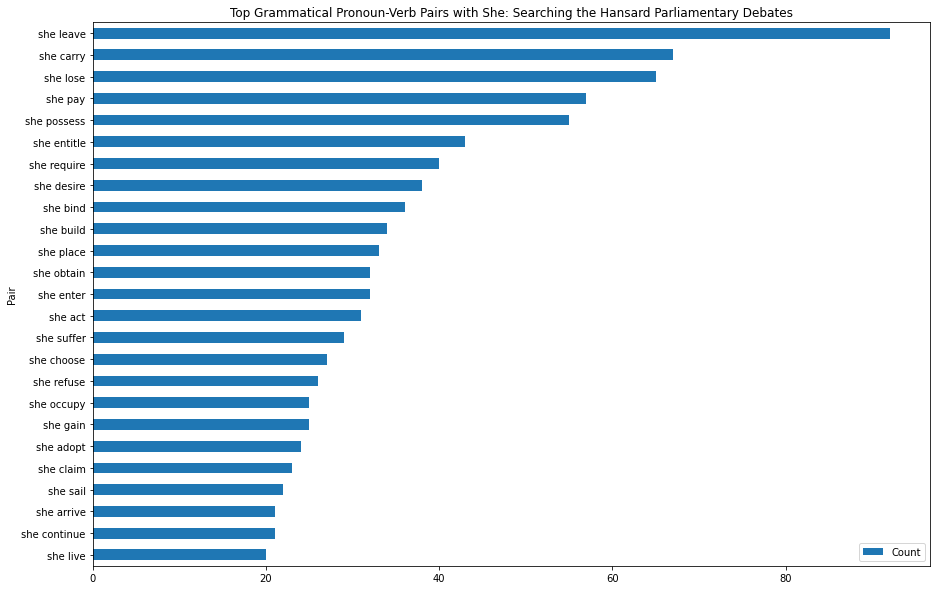

In [34]:
# extract grammatical pronoun-verb pairs where she is subject
def extractFemalePairs(pairs):
    regex = re.compile('she ')
    female = [word for word in lowercase_pairs if regex.match(word)]
    return female

female = extractFemalePairs(lowercase_pairs)

# remove stop words
female_no_stopwords = removeStopWords(female)

# create a dictionary with each unique pair and its frequency
female_dictionary = countWords(female_no_stopwords)

# create a data frame from our dictionary of grammatical pairs
female_pronoun_verb_counts = pd.DataFrame(female_dictionary.items(),columns = ['Pair','Count'])

# arrange in ascending order
female_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=False)

# take a subset of the data
top_female_pronoun_verb_counts = female_pronoun_verb_counts[:25].copy()

# set the parameters of the visualization
plt.rcParams['figure.figsize'] = [15, 10]

# sort the pairs for visualization
top_female_pronoun_verb_counts.sort_values(by=['Count'], inplace=True, ascending=True)

# render visualization
top_female_pronoun_verb_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Pronoun-Verb Pairs with She: Searching the Hansard Parliamentary Debates")

### Assignment

1. extract and visualize lemmatized, gendered adjective-noun pairs (i.e. women, man + their adjectives) from the same 1870s subset of the Hansard data.

    - Note: you can accomplish this task by modifying the pre-existing code in _this Notebook_. 

2. Write down four observations based on your visualizations.

    - For example, you might observe that in your top adjective-noun pairs the noun woman frequently co-occures with the adjective married, but the noun man never does. Instead, man is paired with adjectives like scientific or competent.

3. Contextualize your observations by reviewing [the Hansard debates API](https://hansard.parliament.uk/search?searchTerm=ngrams&partial=False). 

    - In other words, if you are interested in adjective noun pairs where women are called "masculine" you might search "masculine woman" in the Hansard API and contextualize your findings by reading the applicable sections.

4. Write a paragraph describing how you could continue to mine Hansard for results that would yield a more meaningful and complex analysis.

    - For example, you could say: "my research focused on "X, Y, and Z" but a more complex analysis might also ask: "A, B, and C." 

Remember to list dates if you reference any specific debates.

### Getting Started on Your Assignment

As mentioned, you can modiy the code in this Notebook to extract female adjective-noun pairs. To see what I mean, let's get started on this problem together.

We know we already have functions that count pairs, create DataFrames, and visualize our results. Therefore, we just need to change the code that determines which pairs are extracted. Instead of extracting noun-verb pairs we want to extract adjective-noun pairs. 

So, let's return to the `extractPairs()` function and modify it for our assignment. Instead of using the symbols `nsubj` (for noun subject), `nsubjpass` (for passive noun subject) and `VERB`, we will use `amod` (for adjectival modifier), `acomp` (for adjectival complement), and `NOUN`.

In [37]:
from spacy.symbols import amod, acomp, NOUN

def extractAdjNounPairs(spacy_doc_object):
    pairs = []
    for doc in spacy_doc_object['parsed_text']:
        for adjective in doc:
            if adjective.dep == amod or adjective.dep == acomp and adjective.head.pos == NOUN: # or adjective.dep == ccomp or adjective.dep == conj 
                extracted_pairs = adjective.text, adjective.head.lemma_
                concat_extracted_pairs = ' '.join(extracted_pairs)
                pairs.append(str(concat_extracted_pairs))
    return pairs

adjective_noun_pairs = extractAdjNounPairs(hansard_text)

In [38]:
adjective_noun_pairs[:30]

['humble address',
 'Most gracious',
 'lenient eye',
 'recent indisposition',
 'serious nothing',
 'gracious intention',
 'important Session',
 'existing relation',
 'satisfactory settlement',
 'serious consequence',
 'judicious policy',
 'noble Lord',
 'conciliatory disposition',
 'other power',
 'great power',
 'present time',
 'favourable solution',
 'noble Lord',
 'such country',
 'powerful country',
 'important subject',
 'general feeling',
 'present state',
 'abundant evidence',
 'immediate legislation',
 'many case',
 'Parliamentary tribunal',
 'other source',
 'crying necessity',
 'defined measure']

Like our previous code, we can transform each pair to lower case so the same word with a different case is not counted separately. In other words, we don't want to count Woman and woman separately.

In [39]:
lowercase_adjective_noun_pairs = [word.lower() for word in adjective_noun_pairs]

Now instead of extracting pairs with the regular expression "she " we can extract pairs with the regular expression " woman."

In [40]:
def extractFemaleAdjNounPairs(lowercase_adjective_noun_pairs):
    regex = re.compile(' woman')
    female = [word for word in lowercase_adjective_noun_pairs if regex.search(word)]
    return female

female_adj_noun_pairs = extractFemaleAdjNounPairs(lowercase_adjective_noun_pairs)

In [42]:
female_adj_noun_pairs[:30]

['married woman',
 'married woman',
 'few woman',
 'effect—"drunken woman',
 'english woman',
 'other woman',
 'such woman',
 'mostly woman',
 'old woman',
 'unfortunate woman',
 'english woman',
 'dying woman',
 'old woman',
 'married woman',
 'holy woman',
 'helpless woman',
 'married woman',
 'deprive woman',
 'old woman',
 'unmarried woman',
 'same woman',
 'married woman',
 'many woman',
 'honest woman',
 'canaanitish woman',
 'english woman',
 'unhappy woman',
 'other woman',
 'poor woman',
 'unhappy woman']

We can now use our functions to count and visualize our data.

<AxesSubplot:title={'center':'Top Grammatical Adjective-Noun Pairs with Woman: Searching the Hansard Parliamentary Debates'}, ylabel='Pair'>

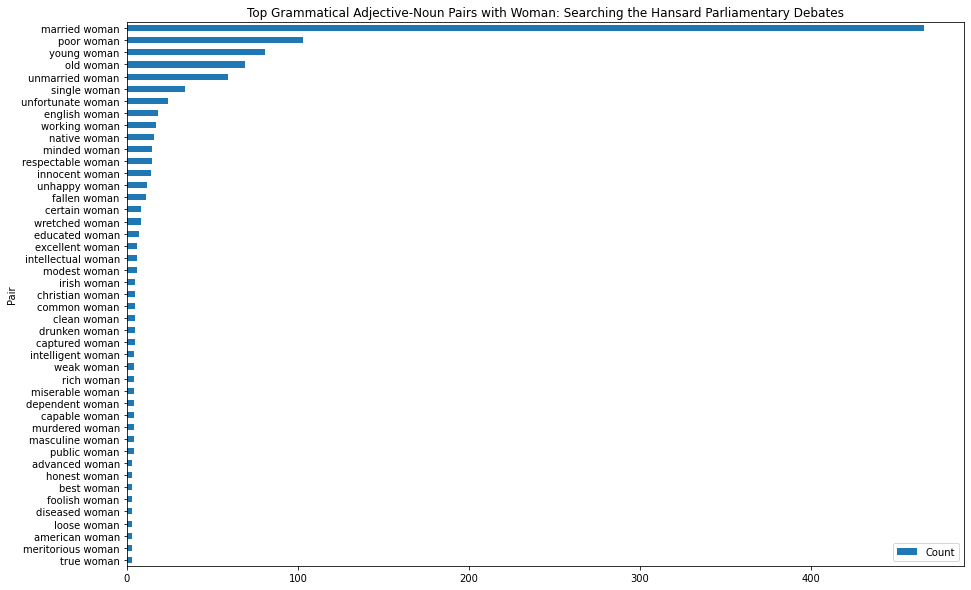

In [43]:
# remove stop words
female_adj_noun_pairs_no_stopwords = removeStopWords(female_adj_noun_pairs)

# create a dictionary with each unique pair and its frequency
female_adj_noun_dictionary = countWords(female_adj_noun_pairs_no_stopwords)

# create a data frame from our dictionary of grammatical pairs
female_adj_noun_df = pd.DataFrame(female_adj_noun_dictionary.items(),columns = ['Pair','Count'])

# arrange in ascending order
female_adj_noun_df.sort_values(by=['Count'], inplace=True, ascending=False)

# take a subset of the data
top_female_adj_noun_counts = female_adj_noun_df[:45].copy()

# set the parameters of the visualization
plt.rcParams['figure.figsize'] = [15, 10]

# sort the pairs for visualization
top_female_adj_noun_counts.sort_values(by=['Count'], inplace=True, ascending=True)

# render visualization
top_female_adj_noun_counts.plot.barh(x = "Pair", y = "Count",
            title = "Top Grammatical Adjective-Noun Pairs with Woman: Searching the Hansard Parliamentary Debates")

Now it's your turn to finish the assignment by repeating the process for "man" and answering the rest of the questions listed in the Assignment section.